In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('/Users/lijiazheng/Desktop/python/housing.csv')

In [3]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [13]:
data.info()
print(data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
(20640, 10)


In [4]:
data.dropna(inplace = True)

In [5]:
X = data.drop(['median_house_value'],axis = 1)
y = data['median_house_value']

In [6]:
def create_features(X, y=None, columns=None):
    data = X.copy()
    if y is not None:  
        data = data.join(y)
    
    data['total_rooms'] = np.log(data['total_rooms'] + 1)
    data['total_bedrooms'] = np.log(data['total_bedrooms'] + 1)
    data['population'] = np.log(data['population'] + 1)
    data['households'] = np.log(data['households'] + 1)
    
    # Create dummy variables
    dummies = pd.get_dummies(data.ocean_proximity)
    
    # Ensure consistent columns if columns parameter is provided
    if columns:
        missing_cols = set(columns) - set(dummies.columns)
        for c in missing_cols:
            dummies[c] = 0
        dummies = dummies[columns]
    
    data = data.join(dummies).drop(['ocean_proximity'], axis=1)
    data['bedroom_ratio'] = data['total_bedrooms'] / data['total_rooms']
    data['household_rooms'] = data['total_rooms'] / data['households']

    return data


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>,
        <Axes: title={'center': 'total_rooms'}>],
       [<Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>,
        <Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>],
       [<Axes: title={'center': 'median_house_value'}>,
        <Axes: title={'center': '<1H OCEAN'}>,
        <Axes: title={'center': 'INLAND'}>,
        <Axes: title={'center': 'ISLAND'}>],
       [<Axes: title={'center': 'NEAR BAY'}>,
        <Axes: title={'center': 'NEAR OCEAN'}>,
        <Axes: title={'center': 'bedroom_ratio'}>,
        <Axes: title={'center': 'household_rooms'}>]], dtype=object)

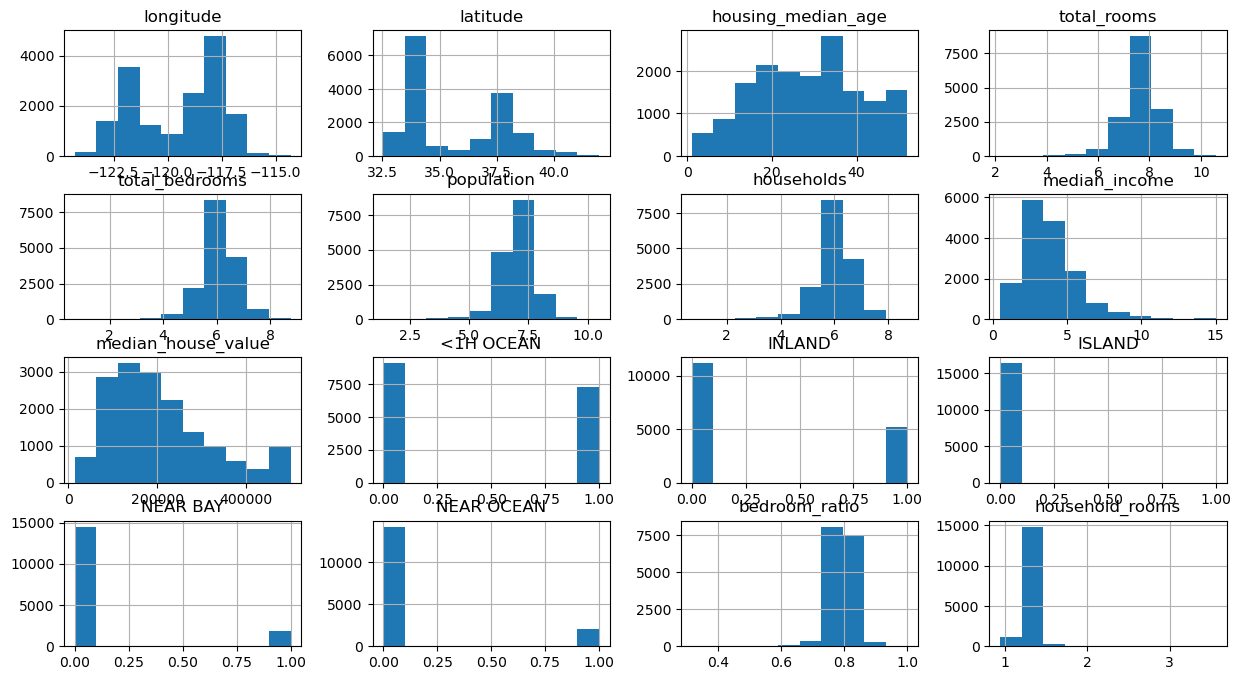

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
train_data = create_features(X_train, y_train)
train_data.hist(figsize = (15,8))

In [8]:
test_data = create_features(X_test, y_test, columns = 
                            list(train_data.columns.difference(X_train.columns).
                                 difference(['bedroom_ratio', 'household_rooms','median_house_value'])))

<Axes: >

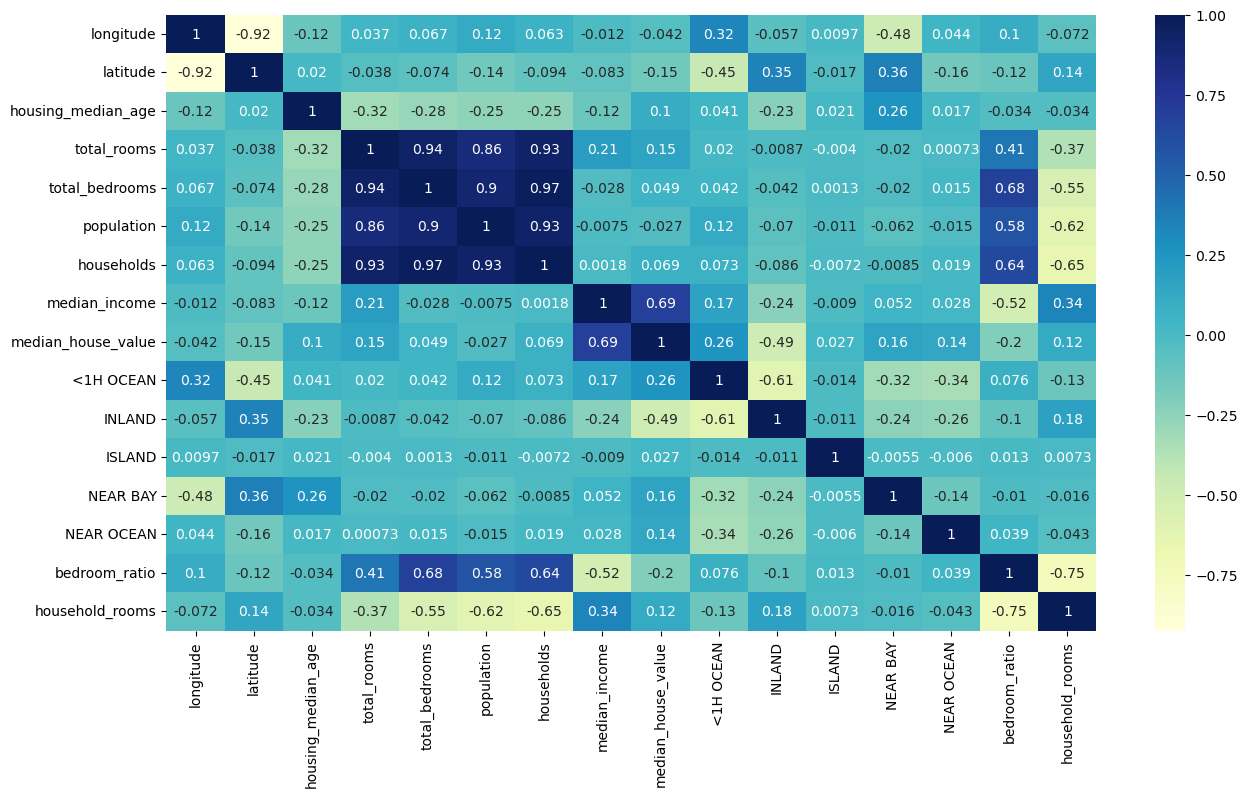

In [9]:
plt.figure(figsize = (15,8))
sns.heatmap(train_data.corr(),annot = True, cmap = 'YlGnBu')

<Axes: xlabel='latitude', ylabel='longitude'>

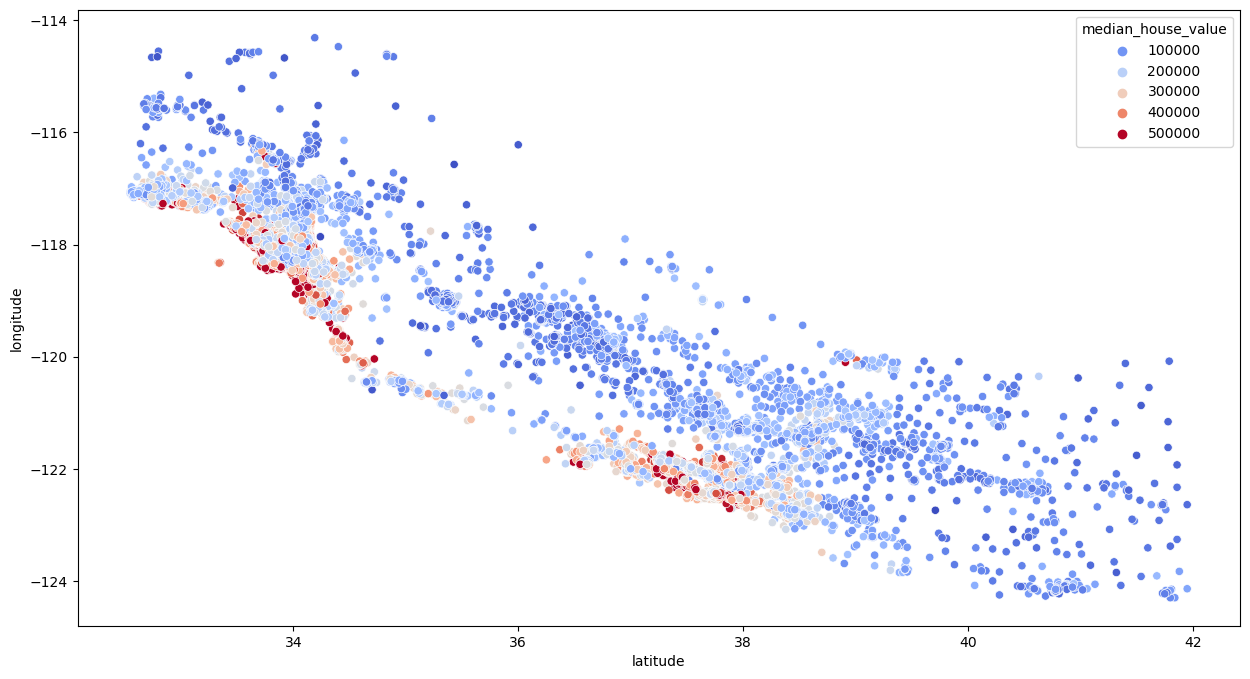

In [10]:
plt.figure(figsize = (15,8))
sns.scatterplot(x = 'latitude',y = 'longitude',data = train_data,hue = 'median_house_value',
                palette = 'coolwarm')

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train, y_train = train_data.drop(['median_house_value'], axis = 1), train_data['median_house_value']
X_train_s = scaler.fit_transform(X_train)
X_test, y_test = test_data.drop(['median_house_value'], axis = 1), test_data['median_house_value']
X_test_s = scaler.fit_transform(X_test)


reg = LinearRegression()
reg.fit(X_train_s, y_train)


LinearRegression()

In [12]:
reg.score(X_test_s,y_test)

0.6759676540494641

In [23]:
coefficients = reg.coef_

feature_names = X_train.columns
feature_importance = pd.DataFrame(coefficients, index=feature_names, columns=['Coefficient'])

feature_importance['Absolute_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Absolute_Coefficient', ascending=False)

print(feature_importance)

                      Coefficient  Absolute_Coefficient
total_bedrooms      100378.751620         100378.751620
median_income        80246.684450          80246.684450
population          -66053.688954          66053.688954
latitude            -60874.150706          60874.150706
total_rooms         -59917.273250          59917.273250
longitude           -58750.777447          58750.777447
households           35669.461403          35669.461403
housing_median_age   13495.208606          13495.208606
bedroom_ratio       -11660.681420          11660.681420
INLAND              -10097.670141          10097.670141
<1H OCEAN             6140.523244           6140.523244
NEAR OCEAN            3599.497271           3599.497271
ISLAND                2392.233184           2392.233184
NEAR BAY              1328.656992           1328.656992
household_rooms        373.032884            373.032884


Random Forest

In [24]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor()

forest.fit(X_train, y_train)

RandomForestRegressor()

In [25]:
forest.score(X_test,y_test)

0.8063180973711155

In [ ]:
import shap
explainer = shap.TreeExplainer(forest)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train.iloc[:10])

individual_shap_values = explainer.shap_values(X_test.iloc[0])
shap.initjs()
shap.force_plot(explainer.expected_value[0], individual_shap_values[0], X_test.iloc[0])

In [26]:
from sklearn.model_selection import GridSearchCV

forest = RandomForestRegressor()
param_grid = {
    "n_estimators" : [30, 50, 100],
    "max_features" : [8, 10, 12],
    "max_depth" :[None, 4, 8]
}

grid_search = GridSearchCV(forest, param_grid, cv = 5,
                          scoring = "neg_mean_squared_error",
                          return_train_score = True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 4, 8], 'max_features': [8, 10, 12],
                         'n_estimators': [30, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [27]:
best_forest = grid_search.best_estimator_
best_forest 

RandomForestRegressor(max_features=10)

In [28]:
best_forest.score(X_test,y_test)  

0.8110869124051705

In [29]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

# Create AdaBoost with a DecisionTreeRegressor as the base estimator
ada_boost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor())
ada_boost.fit(X_train, y_train)
ada_boost.score(X_test,y_test)

/Users/lijiazheng/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.8122080119358035

In [31]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

# Create AdaBoost with a DecisionTreeRegressor as the base estimator
ada_boost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor())

param_grid = {
    "n_estimators": [50, 100, 150],  
    "learning_rate": [0.1, 0.2, 0.3],  
    "base_estimator__max_depth": [None, 4, 8],  
}

# Create GridSearchCV object
grid_search = GridSearchCV(ada_boost, param_grid, cv=5,
                           scoring="neg_mean_squared_error",
                           return_train_score=True)

grid_search.fit(X_train, y_train)
best_ada_boost = grid_search.best_estimator_

print(best_ada_boost)

score = best_ada_boost.score(X_test, y_test)
print("Test score: ", score)

/Users/lijiazheng/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/lijiazheng/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/lijiazheng/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/lijiazheng/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/lijiazheng/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will b

/Users/lijiazheng/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/lijiazheng/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/lijiazheng/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/lijiazheng/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/lijiazheng/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will b

/Users/lijiazheng/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/lijiazheng/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/lijiazheng/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/lijiazheng/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/lijiazheng/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will b

/Users/lijiazheng/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/lijiazheng/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/lijiazheng/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/lijiazheng/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/lijiazheng/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will b

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), learning_rate=0.3,
                  n_estimators=150)
Test score:  0.8118646082292291


In [38]:
import xgboost as xgb


X_train.columns = [str(col).replace('[', '').replace(']', '').replace('<', '') for col in X_train.columns]
X_test.columns = [str(col).replace('[', '').replace(']', '').replace('<', '') for col in X_test.columns]

# Now, create and train the XGBoost model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror',  
                          learning_rate = 0.1,
                          max_depth = 6, 
                          alpha = 10, 
                          n_estimators = 100)
xg_reg.fit(X_train, y_train)

# Evaluate the model
score = xg_reg.score(X_test, y_test)
print("XGBoost Model Score: ", score)


XGBoost Model Score:  0.8263947132987729


In [41]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [500, 750, 1000],  
    'learning_rate': [0.01, 0.1, 0.2], 
    'max_depth': [8, 10, 12]          
}
xgb_reg = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5, verbose=1)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 1000}
Best score: -2178423227.051329


In [42]:
from sklearn.metrics import mean_squared_error, r2_score
predictions = best_model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

r2 = r2_score(y_test, predictions)

print("Mean Squared Error (MSE) on Test Set:", mse)
print("Root Mean Squared Error (RMSE) on Test Set:", rmse)
print("R-squared Score on Test Set:", r2)

Mean Squared Error (MSE) on Test Set: 2041154958.8971941
Root Mean Squared Error (RMSE) on Test Set: 45179.14296328776
R-squared Score on Test Set: 0.8418324204940282


In [ ]:
!pip install lime
from lime.lime_tabular import LimeTabularExplainer

# Initialize the LIME explainer
explainer = LimeTabularExplainer(X_train.values,
                                 feature_names=X_train.columns,
                                 class_names=['median_house_value'],
                                 mode='regression')

# Explain a single instance
i = 20  # Index of the instance in the test set you want to explain
exp = explainer.explain_instance(X_test.values[i], ada_boost.predict, num_features=10)

# Display the explanation
exp.show_in_notebook(show_table=True)

K-fold cross validation

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

scores = []
mse_scores = []

def cross_validate_model(model, X, y, n_splits=5, random_state=None):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    scores = []
    mse_scores = []
    scaler = StandardScaler()  

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        model.fit(X_train_scaled, y_train)

        scores.append(model.score(X_test_scaled, y_test))
        y_pred = model.predict(X_test_scaled)
        mse_scores.append(mean_squared_error(y_test, y_pred))

    return np.mean(scores), np.mean(mse_scores)

full_data = create_features(X)  
full_X = full_data.drop(['median_house_value'], axis=1)
full_y = full_data['median_house_value']

# For Linear Regression
lin_reg = LinearRegression()
avg_r2_lin_reg, avg_mse_lin_reg = cross_validate_model(lin_reg, full_X, full_y)
print(f"Linear Regression - Avg R^2: {avg_r2_lin_reg}, Avg MSE: {avg_mse_lin_reg}")

# For Random Forest
rf = RandomForestRegressor()
avg_r2_rf, avg_mse_rf = cross_validate_model(rf, full_X, full_y)
print(f"Random Forest - Avg R^2: {avg_r2_rf}, Avg MSE: {avg_mse_rf}")